# PART 1

#### Train 2 different models and get results

#### Creating Image Data Loaders in PyTorch for Deep Learning (CREATING DATALOADER)

#### Importing the Required Module


In [16]:
import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import
argparse


#### Reading the Image Paths and Preparing the CSV File


we will create a CSV file where will will save each of the image paths and the targets

We have encoded the labels in one hot encoding

Head is used to show the csv file

In [17]:
# get all the image paths
image_paths = list(paths.list_images('/Users/chinmay/Desktop/Projects/Finals/train'))

# create an empty DataFrame
data = pd.DataFrame()

labels = []
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    labels.append(label)
    
labels = np.array(labels)
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping an one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")
for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)

# save as csv file
data.to_csv('/Users/chinmay/Desktop/Projects/Finals/train/data.csv', index=False)


# pickle the label binarizer
joblib.dump(lb, '/Users/chinmay/Desktop/Projects/Finals/outputs/lb.pkl')
print('Save the one-hot encoded binarized labels as a pickled file.')
print(data.head())

100%|██████████| 980/980 [00:00<00:00, 4167.98it/s]


The first one hot encoded labels: [0 0 0 0 0 0 0 0 0 1 0 0]
Mapping an one hot encoded label to its category: colon
Total instances: 980
Save the one-hot encoded binarized labels as a pickled file.
                                          image_path  target
0  /Users/chinmay/Desktop/Projects/Finals/train/l...     5.0
1  /Users/chinmay/Desktop/Projects/Finals/train/s...     9.0
2  /Users/chinmay/Desktop/Projects/Finals/train/s...    10.0
3  /Users/chinmay/Desktop/Projects/Finals/train/k...     3.0
4  /Users/chinmay/Desktop/Projects/Finals/train/s...     8.0


#### Importing required packages

In [18]:
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models # for resnet50
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

The next block of code applies a seed to our code for reproducibility and also sets the computation device. The computation device is either the GPU or the CPU.

In [19]:
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cpu


#### Read training data

In [21]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('/Users/chinmay/Desktop/Projects/Finals/train/data.csv')
X = df.image_path.values
y = df.target.values
print(X)
print(y)

['/Users/chinmay/Desktop/Projects/Finals/train/lung 3/40071_95769_A_2_4.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/skin_2/40155_94574_B_6_8.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/small_intestine/40140_85634_A_4_2.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/kidney/40092_85426_A_8_5.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/skin_1/40070_85003_B_7_1.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/small_intestine/40066_141607_A_4_2.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/small_intestine/40067_100847_A_4_2.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/small_intestine/40126_85296_A_5_2.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/skin_1/40101_88202_B_9_1.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/pancreas/40067_100847_A_2_3.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/spleen/40061_85040_B_7_4.tif'
 '/Users/chinmay/Desktop/Projects/Finals/train/skin_1/40084_84728_B_7_1.tif'
 '/Users/chinmay/Desktop/Projects/F

In [22]:
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.25, random_state=42))

#### Creating the Dataset Module (APPLYING DATA RESIZING AND NORMALIZING)

1. As we only have around 1000 training images in our dataset, therefore we will employ image augmentation using the albumentations package. 
2. Along with that we will also be using pretrained ResNet-50 model so that we can get better performance on such small dataset.

In [23]:
class NaturalImageDataset(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=1.0),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=30,
                    p=1.0
                ),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

#### Creating the train_data and test_data.

In [24]:
train_data = NaturalImageDataset(xtrain, ytrain, tfms=1)
test_data = NaturalImageDataset(xtest, ytest, tfms=0)

#### create the iterable data loader

In [25]:

# dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [26]:
print('Loading label binarizer...')
lb = joblib.load('/Users/chinmay/Desktop/Projects/Finals/outputs/lb.pkl')

Loading label binarizer...


#### Defining the ResNet-50 Model

1. Loading the ResNet-50 model with the ImageNet weights. 
2. Freezing the hidden layers. This will prevent from backpropagating the gradients of the hidden layers so that those weights do not change while training. 
3. Finally, we are fine-tuning the last classification layer of the ResNet-50 model

In [27]:
def model(pretrained, requires_grad):
    
    model = models.resnet50(progress=True, pretrained=pretrained)
    # freeze hidden layers
    
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    
    # train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    
    model.fc = nn.Linear(2048, len(lb.classes_))
    return model
model = model(pretrained=True, requires_grad=False).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

1. Use the SGD optimizer with the learning rate of 0.0001 and weight decay of 0.0005. 
2. For the criterion, used CrossEntropyLoss().

In [28]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
# loss function
criterion = nn.CrossEntropyLoss()

#### The Validation Function

In [29]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss/len(test_dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

#### The training function


In [30]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

#### We are running the fit() and validate() function 20 epochs

In [33]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1 of 20
Training


<ipython-input-23-19ca151e9b2f>:33: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)
23it [03:08,  8.18s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0668, Train Acc: 46.53
Validating


8it [01:00,  7.58s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0694, Val Acc: 45.71
Epoch 2 of 20
Training


23it [03:07,  8.13s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0657, Train Acc: 48.71
Validating


8it [01:00,  7.57s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0683, Val Acc: 46.12
Epoch 3 of 20
Training


23it [03:05,  8.07s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0648, Train Acc: 51.43
Validating


8it [01:00,  7.52s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0676, Val Acc: 47.35
Epoch 4 of 20
Training


23it [03:05,  8.05s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0638, Train Acc: 51.02
Validating


8it [01:00,  7.53s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0667, Val Acc: 49.80
Epoch 5 of 20
Training


23it [03:05,  8.07s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0633, Train Acc: 51.56
Validating


8it [01:00,  7.54s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0659, Val Acc: 46.94
Epoch 6 of 20
Training


23it [03:07,  8.17s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0623, Train Acc: 53.74
Validating


8it [01:00,  7.57s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0654, Val Acc: 47.76
Epoch 7 of 20
Training


23it [03:04,  8.02s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0612, Train Acc: 55.10
Validating


8it [00:59,  7.42s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0644, Val Acc: 49.80
Epoch 8 of 20
Training


23it [03:04,  8.03s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0608, Train Acc: 58.10
Validating


8it [00:59,  7.49s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0639, Val Acc: 48.16
Epoch 9 of 20
Training


23it [03:03,  7.97s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0600, Train Acc: 56.05
Validating


8it [01:00,  7.51s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0633, Val Acc: 49.39
Epoch 10 of 20
Training


23it [03:04,  8.01s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0595, Train Acc: 53.74
Validating


8it [00:59,  7.50s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0624, Val Acc: 49.80
Epoch 11 of 20
Training


23it [03:03,  7.99s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0589, Train Acc: 56.60
Validating


8it [00:59,  7.44s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0620, Val Acc: 51.43
Epoch 12 of 20
Training


23it [03:07,  8.14s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0580, Train Acc: 60.00
Validating


8it [01:00,  7.55s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0614, Val Acc: 51.43
Epoch 13 of 20
Training


23it [03:07,  8.14s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0574, Train Acc: 58.91
Validating


8it [00:59,  7.48s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0606, Val Acc: 52.24
Epoch 14 of 20
Training


23it [03:06,  8.11s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0569, Train Acc: 59.46
Validating


8it [00:59,  7.47s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0603, Val Acc: 51.02
Epoch 15 of 20
Training


23it [03:07,  8.14s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0566, Train Acc: 59.05
Validating


8it [01:00,  7.59s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0598, Val Acc: 51.02
Epoch 16 of 20
Training


23it [03:07,  8.15s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0557, Train Acc: 61.09
Validating


8it [01:00,  7.61s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0593, Val Acc: 50.20
Epoch 17 of 20
Training


23it [03:09,  8.23s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0549, Train Acc: 61.36
Validating


8it [01:02,  7.82s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0587, Val Acc: 52.24
Epoch 18 of 20
Training


23it [03:08,  8.22s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0544, Train Acc: 62.86
Validating


8it [00:59,  7.50s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0580, Val Acc: 51.43
Epoch 19 of 20
Training


23it [03:07,  8.15s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0533, Train Acc: 64.76
Validating


8it [01:03,  7.95s/it]                       
  0%|          | 0/22 [00:00<?, ?it/s]

Val Loss: 0.0572, Val Acc: 53.06
Epoch 20 of 20
Training


23it [03:11,  8.33s/it]                        
  0%|          | 0/7 [00:00<?, ?it/s]

Train Loss: 0.0535, Train Acc: 62.18
Validating


8it [01:00,  7.55s/it]                       

Val Loss: 0.0572, Val Acc: 52.65
82.380 minutes


1. Appending the loss and accuracy values to lists.
2. For the fit() function, we are storing the values in train_loss and train_accuracy. And for the validation() function, storing them in val_loss and val_accuracy.

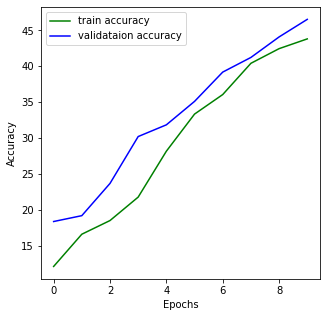

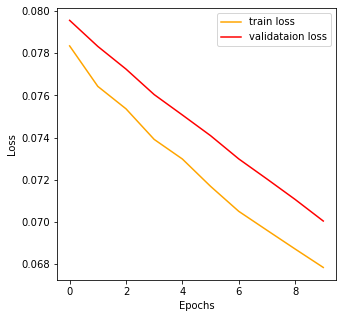

In [32]:
# accuracy plots
plt.figure(figsize=(5, 5))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/Users/chinmay/Desktop/Projects/Finals/outputs/accuracy.png')
plt.show()
# loss plots
plt.figure(figsize=(5, 5))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/Users/chinmay/Desktop/Projects/Finals/outputs/loss.png')
plt.show()

#### Validation and Loss curve

1. We can see that the validation accuracy is constantly higher than the training accuracy until the end of the training. 
2. This is most likely because the model gets to see very less number of validation examples which it finds extremely easy to classify. And due to the data augmentation, the ResNet-50 neural network model finds the training examples just a bit more difficult.

#### Saving moodel

Training for more epochs is also not going to help as the model will surely overfit on such a small dataset. 
In fact, the ResNet-50 neural network model is an overkill for this dataset containing only around 1100 images. Now, there are some downsides to the results that we are getting. Most probably, the classification result for some images is going to be wrong during testing.

# Building CNN using DataLoader

In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib


/Users/chinmay/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/chinmay/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: /Users/chinmay/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 14.0.0 or later, but libjpeg.9.dylib provides version 12.0.0
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)


cpu


#### Applying transforms 

Resizing the image to size 150*150

Horizontally flip the given image randomly with a given probability. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions.

applied transformation on image = (image - mean) / std where mean=0.5 and std = 0.5

ToTensor converts numpy into tensor

In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

#### Dataloader
 

Reading image from folder train_path for testing and test_path for training
Here batch size is considered 64 for training and 32 fir testing.
Chosen batch size on the memory avalibility of system... More batch size faster is the computation 

In [5]:

#Path for training and testing directory
train_path = '/Users/chinmay/Desktop/Projects/Finals/train'
test_path = '/Users/chinmay/Desktop/Projects/Finals/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

To get the classes of the training images.

In [7]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [8]:
print(classes)

['.DS_Store', 'colon', 'endometrium_1', 'endometrium_2', 'kidney', 'liver', 'lung 3', 'lymph_node', 'pancreas', 'skin_1', 'skin_2', 'small_intestine', 'spleen']


#### Below written the code for CNN



This uses the in built data dataloader. 

HERE:

in_features = Number of input features 

out_features = Number of output features

kernal size = widthxheight of the filter mask

Stride  = This denotes how many steps we are moving in each steps in convolution

Padding = Process of adding zeros to the input matrix symmetrically

In [9]:

class ConvNet(nn.Module):
    def __init__(self,num_classes=10):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        
        
        #Shape= (256,12,75,75)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        
        #Shape= (256,20,75,75)
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        #Feed forwad function
    
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output
 

In [10]:
model=ConvNet(num_classes=12).to(device)

#### CrossEntropyLoss is used for calculating loss

In [11]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

### Calculate the size of training and test data

In [13]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.tif'))
test_count=len(glob.glob(test_path+'/**/*.tif'))

In [14]:
print(train_count,test_count)

980 600


#### The below code is used for training the model and on dataset 
#### model.train() used for Evaluation and training on training dataset
#### model.eval() Evaluation on testing dataset
#### Train accuracy and train loss is stored for each epoch

In [15]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    
       

Epoch: 0 Train Loss: tensor(36.6085) Train Accuracy: 0.1846938775510204 Test Accuracy: 0.195
Epoch: 1 Train Loss: tensor(12.0783) Train Accuracy: 0.41836734693877553 Test Accuracy: 0.2633333333333333
Epoch: 2 Train Loss: tensor(6.4840) Train Accuracy: 0.5306122448979592 Test Accuracy: 0.35
Epoch: 3 Train Loss: tensor(2.7652) Train Accuracy: 0.6928571428571428 Test Accuracy: 0.36333333333333334
Epoch: 4 Train Loss: tensor(2.2403) Train Accuracy: 0.746938775510204 Test Accuracy: 0.42333333333333334
Epoch: 5 Train Loss: tensor(1.2024) Train Accuracy: 0.8285714285714286 Test Accuracy: 0.40166666666666667
Epoch: 6 Train Loss: tensor(0.6059) Train Accuracy: 0.8918367346938776 Test Accuracy: 0.4033333333333333
Epoch: 7 Train Loss: tensor(0.9730) Train Accuracy: 0.8591836734693877 Test Accuracy: 0.37333333333333335
Epoch: 8 Train Loss: tensor(0.4715) Train Accuracy: 0.9193877551020408 Test Accuracy: 0.365
Epoch: 9 Train Loss: tensor(0.4270) Train Accuracy: 0.9153061224489796 Test Accuracy: 0.3

#### Conclusion from the result.

1. The above model looks good for train accuracy but test accuracy is significantly low.
2. This shows the model is overfit. The probable cause of overfitting in this case is due to noisy training data.
3. In the transfor the values choosen randomly while training. This may result in excluding important feature while training. We can avoid this problem by finding the various combinations of mean, std. 
4. Moreover the CNN we build in this example is build based on the assumed value. This can be avoided and hyperparameter tuning can be done to get the best parameters for the model 


# PART 2

### Train a classification model USING PRE TRAIN MODEL VGG16

#### Importing Required Modules and Libraries


In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Downloading and Preparing the Dataset


In [ ]:
# VGG network takes an input image of size 224×224 by default hence resizing to 224*224
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [37]:

train_path = '/Users/chinmay/Desktop/Projects/Finals/train'
test_path = '/Users/chinmay/Desktop/Projects/Finals/test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

#### Downloading the VGG16 Network


In [38]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/chinmay/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

#### Freezing Convolution Weights


1. One important thing to notice here is that the classifier model is classifying 1000 classes. 
2. You can observe the very last Linear block to confirm that. 
3. But we need to classify the images into 10 classes only. So, we will change that. Also, we will freeze all the weights of the convolutional blocks. 
4. The model as already learned many features from the ImageNet dataset. So, freezing the Conv2d() weights will make the model to use all those pre-trained weights. 


In [39]:
#kept number of classes = 12 
vgg16.classifier[6].out_features = 12
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

#### CrossEntropyLoss() and SGD() optimizer which works well in most cases

In [40]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

#### validate() method, we are calculating the loss and accuracy

In [41]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

#### fit() method, we are calculating the gradients and backpropagating.

In [42]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

#### Training and validating the model for 10 epochs.  fit() and validate() will return the loss and accuracy values for each epoch.

In [43]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

<ipython-input-23-19ca151e9b2f>:33: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


Train Loss: 0.1925, Train Acc: 7.76
Train Loss: 0.0667, Train Acc: 29.66
Train Loss: 0.0535, Train Acc: 43.54
Train Loss: 0.0495, Train Acc: 45.71
Train Loss: 0.0464, Train Acc: 47.07
Train Loss: 0.0438, Train Acc: 51.56
Train Loss: 0.0409, Train Acc: 55.92
Train Loss: 0.0408, Train Acc: 56.87
Train Loss: 0.0392, Train Acc: 57.82
Train Loss: 0.0369, Train Acc: 60.41
160.1804185986519 minutes


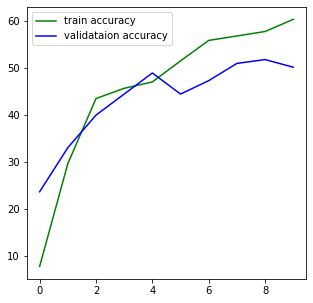

In [58]:
plt.figure(figsize=(5, 5))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

#### We are getting fairly good results, but we can do even better. We can fine-tune the features model values of VGG16 and try to get even more accuracy. One way to get started is to freeze some layers and train some others. We have only tried freezing all of the convolution layers. Be sure to try that out.

# Conclusion:

1. Hyperparameter tuning should be done to get more accurate model.
2. Training data is less and less diverese with more training data testing accuracy can be increased. 
3. Assumption of random values for data transformation may lead bad results. Exploratory data analysis is needed to study data remove noice make data more accurate for training.
